# Trying out Bayesian Flow Networks

Trying out the discrete case.

In [1]:
from jaxtyping import install_import_hook

import train_and_sample as tas
import example_data
import training

In [2]:
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import jax
import optax
from tqdm import tqdm
from functools import partial
from torch.utils.data import DataLoader

### Trying Training

In [3]:
data = example_data.StringDataset("elisroberts", 100, 0.15)

In [4]:
# Initialize model
model = tas.DiscreteOutputDistribution(data.num_cats, data.d)
thetas_prior = jnp.ones((data.num_cats, data.d)) / data.num_cats

variables = model.init(jr.PRNGKey(0), thetas_prior, 1.0)
params = variables["params"]

In [5]:
optim = optax.adam(1e-3)
opt_state = optim.init(params)

In [6]:
batch_size = 16
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=jnp.stack)

In [7]:
NUM_EPOCHS = 2000
losses = []
key = jr.PRNGKey(0)
beta = 4.0
for _ in (pbar := tqdm(range(NUM_EPOCHS))):
    epoch_loss = 0.0
    for x_batch in dataloader:
        key, subkey = jr.split(key)
        loss, params, opt_state = training.make_step_batch(model, x_batch, optim, opt_state, params, beta, key=subkey)
        epoch_loss += loss
    losses.append(epoch_loss)
    pbar.set_description(f"Loss: {epoch_loss:.1f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

Loss: 148.3: 100%|██████████| 2000/2000 [00:30<00:00, 65.08it/s]


In [11]:
sample_key = jr.PRNGKey(0)
output = tas.sample(params, model, beta, 100, key=sample_key)
example_data.detokenize_string(output)

'xcvecbgabzd'

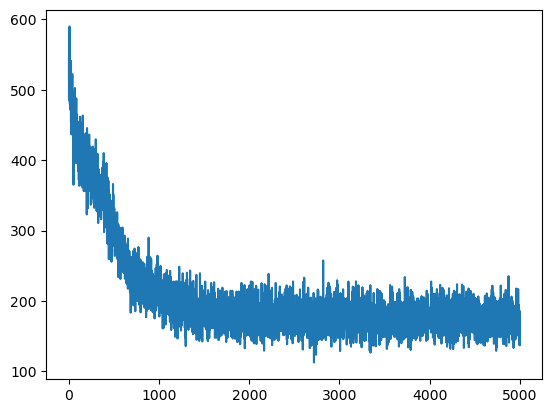

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses)